將上一筆需量加入至模型, "不"使用Sliding Window，
========
並加入 Self Attention/Attention 架構於LSTM 模型中
========

In [134]:
# Import necessary libraries [B]
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
import statsmodels.api as sm  # seasonal trend decomposition
import datetime
from statsmodels.graphics import tsaplots   # autocorrelation
import pymysql
from tensorflow.keras.optimizers import Adam #
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, BatchNormalization, TimeDistributed, Flatten, Bidirectional,Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import optimizers
from time import time
from sklearn import preprocessing, metrics
from joblib import dump, load
from datetime import datetime, timedelta
from scipy.interpolate import lagrange
from scipy.sparse import csr_matrix
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like
from keras_self_attention import SeqSelfAttention
from attention import Attention
from tensorflow.keras.utils import plot_model
%matplotlib inline
# Import necessary libraries [E]

In [135]:
# 參數定義 [B]
today_object = datetime.now()
today = today_object.strftime("%Y-%m-%d-%H-%M-%S")
temperature_zscore_to_path = './../parameter-storage10/zscore/temperature-zscore-{}.bin'.format(today)
pres_zscore_to_path = './../parameter-storage10/zscore/pres-zscore-{}.bin'.format(today)
wind_speed_zscore_to_path = './../parameter-storage10/zscore/wind_speed-zscore-{}.bin'.format(today)
wind_dir_zscore_to_path = './../parameter-storage10/zscore/wind_dir-zscore-{}.bin'.format(today)
max_wind_zscore_to_path = './../parameter-storage10/zscore/max_wind-zscore-{}.bin'.format(today)
r24_zscore_to_path = './../parameter-storage10/zscore/r24-zscore-{}.bin'.format(today)
huvi_zscore_to_path = './../parameter-storage10/zscore/huvi-zscore-{}.bin'.format(today)
apparent_temp_zscore_to_path = './../parameter-storage10/zscore/apparent_temp-zscore-{}.bin'.format(today)

T_Min_zscore_to_path = './../parameter-storage10/zscore/T_Min-zscore-{}.bin'.format(today)
T_Max_zscore_to_path = './../parameter-storage10/zscore/T_Max-zscore-{}.bin'.format(today)
day_of_year_zscore_to_path = './../parameter-storage10/zscore/day_of_year-zscore-{}.bin'.format(today)
data_week_zscore_to_path = './../parameter-storage10/zscore/data_week-zscore-{}.bin'.format(today)
data_hour_zscore_to_path = './../parameter-storage10/zscore/data_hour-zscore-{}.bin'.format(today)
data_minute_zscore_to_path = './../parameter-storage10/zscore/data_minute-zscore-{}.bin'.format(today)
minutes_of_the_day_zscore_to_path = './../parameter-storage10/zscore/minutes_of_the_day-zscore-{}.bin'.format(today)
demand_zscore_to_path = './../parameter-storage10/zscore/demand-zscore-{}.bin'.format(today)

data_weekday_encode_to_path = './../parameter-storage10/zscore/data_weekday-encode-{}.bin'.format(today)
period_type_encode_to_path = './../parameter-storage10/zscore/period_type-encode-{}.bin'.format(today)

simple_LSTM_modal_y1_save_path = './../parameter-storage10/modal/simple-LSTM-modal-y1-{}.h5'.format(today)
simple_LSTM_modal_y2_save_path = './../parameter-storage10/modal/simple-LSTM-modal-y2-{}.h5'.format(today)
simple_LSTM_modal_no_weather_save_path = ''.format(today)



zscore_pid_path = './../parameter-storage10/pid/zscore-pid.pid'
encode_pid_path = './../parameter-storage10/pid/encode-pid.pid'
modal_pid_path = './../parameter-storage10/pid/modal-pid.pid'
stacked_modal_pid_path = './../parameter-storage10/pid/stacked-modal-pid.pid'
bidirectional_modal_pid_path = './../parameter-storage10/pid/bidirectional-modal-pid.pid'
simple_kmeans_modal_pid_path = './../parameter-storage10/pid/simple-kmeans-modal-pid.pid'
stacked_kmeans_modal_pid_path = './../parameter-storage10/pid/stacked-kmeans-modal-pid.pid'
bidirectional_kmeans_modal_pid_path = './../parameter-storage10/pid/bidirectional-kmeans-modal-pid.pid'

kmeans_pid_path = './../parameter-storage10/pid/kmeans-pid.pid'

In [136]:
# train_begin_date_y1 = '2017-06-08'
# train_end_date_y1 = '2018-06-08'
# train_begin_date_y2 = '2017-06-08'
# train_end_date_y2 = '2019-06-08'
# train_begin_date_y1_2 = '2018-06-08'
# train_end_date_y1_2 = '2019-06-08'
# test_begin_date = '2019-06-08'
# test_end_date = '2020-06-07'

begin_date = '2017-06-08'
end_date = '2022-06-08'
train_begin_date_y2 = '2019-01-01'
train_end_date_y2 = '2021-01-01'
predict_begin_date = '2021-05-01'
predict_end_date = '2021-05-31'
# 參數定義 [E]

In [137]:
# 正規化最大最小值 [B]
temperature_range = np.array([0, 50])
pres_range = np.array([0, 1500])
wind_speed_range = np.array([0, 80])
wind_dir_range = np.array([0, 360])
r24_range = np.array([0, 400])
huvi_range = np.array([0, 30])
day_of_year_range = np.array([1, 366])
week_range = np.array([1, 53])
hour_range = np.array([0, 24])
minute_range = np.array([0, 60])
minutes_of_the_day_range = np.array([0, 86400])
demand_range = np.array([0, 700])
# 正規化最大最小值 [B]

In [138]:
# 參數轉成監督式參數 [B]
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    df_columns_name = df.columns.values
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df_columns_name[j], i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df_columns_name[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df_columns_name[j], i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg
# 參數轉成監督式參數 [E]

In [139]:
# 體感溫度計算 [B]
def c_feel_like(temperature, wind_speed):
    feels_like = int(13.12+(0.615*float(temperature))-(11.37*(float(wind_speed)*3.6)**0.16)+(0.3965*float(temperature))*((float(wind_speed)*3.6)**0.16))
    return feels_like
# 體感溫度計算 [E]

In [ ]:
# 撈取需量資料 [B]
try: 
    conn  =  pymysql.connect ( host = '　' ,  user = '　' ,  passwd = "　" ,  db = 'ncku_demand' ) 
    cur  =  conn.cursor() 
    select_sql = '''SELECT `id`, `demand_min`, `demand_quarter`, `Total_value`, `Temperature`, 
                    `humd`, `pres`, `w_DSD`, `w_DIR`, `h_FX`, `24R`, `h_UVI`, `T_Min`, `T_Max`, 
                    `day_of_year`, `data_week`, `data_date`, `data_hour`, `data_minute`, `data_weekday`, 
                    `minutes_of_the_day`, `period_type`, `datetime`
                    FROM `demand_with_weather_data` 
                    WHERE `datetime` >= '{}' AND `datetime` < '{}'
                    ORDER BY `datetime` '''.format(begin_date, end_date)
    result_object = cur.execute(select_sql)
    results_values_list = cur.fetchall()
    result_key_list = [i[0] for i in cur.description]
    
    dataframe = pd.DataFrame(results_values_list)
    dataframe.columns = result_key_list
    timestamp = pd.to_datetime(dataframe.datetime, infer_datetime_format=True).values.astype(float)
    dataframe['timestamp'] = timestamp.tolist()
    dataframe = dataframe.set_index('datetime')
    cur.close () 
    conn.close()
except Exception as e:
    print(e)
# 撈取需量資料 [E]

In [ ]:
# 刪除不需要的欄位 [B]
dataframe = dataframe.drop(columns=['id', 'demand_min', 'Total_value', 'data_date'])
# 刪除不需要的欄位 [E]

In [ ]:
# 補缺失值 [B]
dataframe = dataframe.interpolate(method="linear") 
# 補缺失值 [E]

In [ ]:
# 體感溫度計算 [B]
dataframe['apparent_temp'] = dataframe.apply(lambda dataframe: c_feel_like(dataframe['Temperature'], dataframe['w_DSD']), axis=1)
# 體感溫度計算 [E]

In [12]:
# 套函式轉為監督式資料 [B]
reframed = series_to_supervised(dataframe, 1, 1)
# 套函式轉為監督式資料 [E]

In [13]:
# 資料正規化 [B]
# 宣告實例 [B]
temperature_zscore = preprocessing.MinMaxScaler()
pres_zscore = preprocessing.MinMaxScaler()
wind_speed_zscore = preprocessing.MinMaxScaler()
wind_dir_zscore = preprocessing.MinMaxScaler()
max_wind_zscore = preprocessing.MinMaxScaler()
r24_zscore = preprocessing.MinMaxScaler()
huvi_zscore = preprocessing.MinMaxScaler()
apparent_temp_zscore = preprocessing.MinMaxScaler()
T_Min_zscore = preprocessing.MinMaxScaler()
T_Max_zscore = preprocessing.MinMaxScaler() 
day_of_year_zscore = preprocessing.MinMaxScaler() 
data_week_zscore = preprocessing.MinMaxScaler() 
data_hour_zscore = preprocessing.MinMaxScaler() 
data_minute_zscore = preprocessing.MinMaxScaler() 
minutes_of_the_day_zscore = preprocessing.MinMaxScaler() 
demand_zscore = preprocessing.MinMaxScaler()
# 宣告實例 [E]
# 資料 reshape [B]
temperature_reshape_data = reframed['Temperature(t)'].values.reshape(-1, 1)
pres_reshape_data = reframed['pres(t)'].values.reshape(-1, 1)
wind_speed_reshape_data = reframed['w_DSD(t)'].values.reshape(-1, 1)
wind_dir_reshape_data = reframed['w_DIR(t)'].values.reshape(-1, 1)
max_wind_reshape_data = reframed['h_FX(t)'].values.reshape(-1, 1)
r24_reshape_data = reframed['24R(t)'].values.reshape(-1, 1)
huvi_reshape_data = reframed['h_UVI(t)'].values.reshape(-1, 1)
apparent_temp_reshape_data = reframed['apparent_temp(t)'].values.reshape(-1, 1)
T_Min_reshape_data = reframed['T_Min(t)'].values.reshape(-1, 1)
T_Max_reshape_data = reframed['T_Max(t)'].values.reshape(-1, 1)
day_of_year_reshape_data = reframed['day_of_year(t)'].values.reshape(-1, 1)
data_week_reshape_data = reframed['data_week(t)'].values.reshape(-1, 1)
data_hour_reshape_data = reframed['data_hour(t)'].values.reshape(-1, 1)
data_minute_reshape_data = reframed['data_minute(t)'].values.reshape(-1, 1)
minutes_of_the_day_reshape_data = reframed['minutes_of_the_day(t)'].values.reshape(-1, 1)
last_demand_reshape_data = reframed['demand_quarter(t-1)'].values.reshape(-1, 1)
demand_reshape_data = reframed['demand_quarter(t)'].values.reshape(-1, 1)
# 資料 reshape [E]
# 部分計算 [B]
temperature_zscore.partial_fit(temperature_range.reshape(-1, 1))
pres_zscore.partial_fit(pres_range.reshape(-1, 1))
wind_speed_zscore.partial_fit(wind_speed_range.reshape(-1, 1))
wind_dir_zscore.partial_fit(wind_dir_range.reshape(-1, 1))
max_wind_zscore.partial_fit(wind_speed_range.reshape(-1, 1))
r24_zscore.partial_fit(r24_range.reshape(-1, 1))
huvi_zscore.partial_fit(huvi_range.reshape(-1, 1))
apparent_temp_zscore.partial_fit(temperature_range.reshape(-1, 1))
T_Min_zscore.partial_fit(temperature_range.reshape(-1, 1))
T_Max_zscore.partial_fit(temperature_range.reshape(-1, 1))
day_of_year_zscore.partial_fit(day_of_year_range.reshape(-1, 1))
data_week_zscore.partial_fit(week_range.reshape(-1, 1))
data_hour_zscore.partial_fit(hour_range.reshape(-1, 1))
data_minute_zscore.partial_fit(minute_range.reshape(-1, 1))
minutes_of_the_day_zscore.partial_fit(minutes_of_the_day_range.reshape(-1, 1))
demand_zscore.partial_fit(demand_range.reshape(-1, 1))
# 部分計算 [E]
# 將部分計算得結果先做正規化 [B]
reframed['Temperature(t)'] = temperature_zscore.transform(temperature_reshape_data)
reframed['pres(t)'] = pres_zscore.transform(pres_reshape_data)
reframed['w_DSD(t)'] = wind_speed_zscore.transform(wind_speed_reshape_data)
reframed['w_DIR(t)'] = wind_dir_zscore.transform(wind_dir_reshape_data)
reframed['h_FX(t)'] = max_wind_zscore.transform(max_wind_reshape_data)
reframed['24R(t)'] = r24_zscore.transform(r24_reshape_data)
reframed['h_UVI(t)'] = huvi_zscore.transform(huvi_reshape_data)
reframed['apparent_temp(t)'] = apparent_temp_zscore.transform(apparent_temp_reshape_data)
reframed['T_Min(t)'] = T_Min_zscore.transform(T_Min_reshape_data)
reframed['T_Max(t)'] = T_Max_zscore.transform(T_Max_reshape_data)
reframed['day_of_year(t)'] = day_of_year_zscore.transform(day_of_year_reshape_data)
reframed['data_week(t)'] = data_week_zscore.transform(data_week_reshape_data)
reframed['data_hour(t)'] = data_hour_zscore.transform(data_hour_reshape_data)
reframed['data_minute(t)'] = data_minute_zscore.transform(data_minute_reshape_data)
reframed['minutes_of_the_day(t)'] = minutes_of_the_day_zscore.transform(minutes_of_the_day_reshape_data)
reframed['demand_quarter(t-1)'] = demand_zscore.transform(last_demand_reshape_data)
reframed['demand_quarter_normalization'] = demand_zscore.transform(demand_reshape_data)
# 將部分計算得結果先做正規化 [E]
# 資料正規化 [E]

In [14]:
# 儲存正規化模型 [B]
dump(temperature_zscore, temperature_zscore_to_path, compress=True)
dump(pres_zscore, pres_zscore_to_path, compress=True)
dump(wind_speed_zscore, wind_speed_zscore_to_path, compress=True)
dump(wind_dir_zscore,wind_dir_zscore_to_path, compress=True)
dump(max_wind_zscore,max_wind_zscore_to_path, compress=True)
dump(r24_zscore,r24_zscore_to_path, compress=True)
dump(huvi_zscore,huvi_zscore_to_path, compress=True)
dump(apparent_temp_zscore, apparent_temp_zscore_to_path, compress=True)
dump(T_Min_zscore, T_Min_zscore_to_path, compress=True) #儲存參數
dump(T_Max_zscore, T_Max_zscore_to_path, compress=True) #儲存參數
dump(day_of_year_zscore, day_of_year_zscore_to_path, compress=True) #儲存參數
dump(data_week_zscore, data_week_zscore_to_path, compress=True) #儲存參數
dump(data_hour_zscore, data_hour_zscore_to_path, compress=True) #儲存參數
dump(data_minute_zscore, data_minute_zscore_to_path, compress=True) #儲存參數
dump(demand_zscore, demand_zscore_to_path, compress=True) #儲存參數
dump(minutes_of_the_day_zscore, minutes_of_the_day_zscore_to_path, compress=True) #儲存參數
# 儲存正規化模型 [E]

['./../parameter-storage10/zscore/minutes_of_the_day-zscore-2022-07-29-13-35-36.bin']

In [15]:
# 儲存檔案最後更新檔案日期 [B]
zscore_pid_write = open(zscore_pid_path, 'w', encoding='utf-8')
zscore_pid_write.write(today)
print(today)
# 儲存檔案最後更新檔案日期 [E]

2022-07-29-13-35-36


In [16]:
# 將分類資料轉為 one hot encoding [B]
data_weekday_encoder = preprocessing.OneHotEncoder(sparse=False)
# period_type_encoder = preprocessing.OneHotEncoder(sparse=False)

data_weekday_values = reframed['data_weekday(t)'].values.reshape(len(reframed['data_weekday(t)']), 1)
# period_type_values = dataframe['period_type'].values.reshape(len(dataframe['period_type']), 1)

data_weekday_values = data_weekday_encoder.fit_transform(data_weekday_values)
# period_type_values = period_type_encoder.fit_transform(period_type_values)

data_weekday_encode_dataframe= pd.DataFrame(data_weekday_values)
# period_type_encode_dataframe= pd.DataFrame(period_type_values)

for i in data_weekday_encode_dataframe:
    reframed['data_weekday_{}(t)'.format(i)] = data_weekday_encode_dataframe[i].values
# for i in period_type_encode_dataframe:
#     dataframe['period_type_{}'.format(i)] = period_type_encode_dataframe[i].values
# 將分類資料轉為 one hot encoding [E]

In [17]:
# 儲存 one hot encodeing模型 [B]
dump(data_weekday_encoder, data_weekday_encode_to_path, compress=True)
# dump(period_type_encoder, period_type_encode_to_path, compress=True)

# 儲存 one hot encodeing模型 [E]

['./../parameter-storage10/zscore/data_weekday-encode-2022-07-29-13-35-36.bin']

In [18]:
# 儲存檔案最後更新檔案日期 [B]
encode_pid_write = open(encode_pid_path, 'w', encoding='utf-8')
encode_pid_write.write(today)
print(today)
# 儲存檔案最後更新檔案日期 [E]

2022-07-29-13-35-36


In [19]:
# 設定要選取的欄位，此參數用意在確保所有所需要的欄位與欄位的順序一致 [B]
selected_column = ['Temperature(t)', 'humd(t)', 'pres(t)', 'w_DSD(t)', 'w_DIR(t)', 'h_FX(t)', '24R(t)', 'h_UVI(t)',
                   'T_Min(t)', 'T_Max(t)', 'day_of_year(t)', 'data_week(t)', 'data_hour(t)',
                   'data_minute(t)', 'minutes_of_the_day(t)', 'apparent_temp(t)', 'demand_quarter(t-1)', 'data_weekday_0(t)',
                   'data_weekday_1(t)', 'data_weekday_2(t)', 'data_weekday_3(t)', 'data_weekday_4(t)',
                   'data_weekday_5(t)', 'data_weekday_6(t)']
# 設定要選取的欄位，此參數用意在確保所有所需要的欄位與欄位的順序一致 [E]
# 將資料拆分成訓練集語測式集 [B]
all_train_features_y2 = reframed.loc[train_begin_date_y2:train_end_date_y2, selected_column]
all_train_labels_y2 = reframed.loc[train_begin_date_y2:train_end_date_y2, 'demand_quarter_normalization']

all_predict_features = reframed.loc[predict_begin_date:predict_end_date, selected_column]
all_predict_labels = reframed.loc[predict_begin_date:predict_end_date, 'demand_quarter_normalization']
# 將資料拆分成訓練集語測式集 [E]

In [20]:
# LSTM 模型需放入三維陣列，因此需先將 dataframe 轉為陣列 [B]
all_train_features_y2 = np.array(all_train_features_y2)
all_predict_features = np.array(all_predict_features)
# LSTM 模型需放入三維陣列，因此需先將 dataframe 轉為陣列 [E]

In [21]:
# 轉為三維陣列 [B]
train_features2_y2 = np.reshape(all_train_features_y2, (all_train_features_y2.shape[0], 1, all_train_features_y2.shape[1]))
predict_features2 = np.reshape(all_predict_features, (all_predict_features.shape[0], 1, all_predict_features.shape[1]))
# 轉為三維陣列 [E]

# 情況 1: 使用 Vanilla LSTM (many to one) + Attention 來訓練模型

In [50]:
''' 使用 Vanilla LSTM (many to one) + Attention 來訓練模型 [B]'''
# 定義模型架構 [B]
vanilla_model = Sequential()
vanilla_model.add(LSTM(50, input_shape=(train_features2_y2.shape[1],train_features2_y2.shape[2]), return_sequences=True)) #X_train.shape[1],X_train.shape[2]
vanilla_model.add(Attention(units=50))
vanilla_model.add(Dense(1, activation='relu'))
# opt = Adam(lr='0.0001')
vanilla_model.compile(loss='mse', optimizer='Adam') 
vanilla_model.summary()
plot_model(vanilla_model, to_file='Vanilla_LSTM_graph_20220729.png')
# 定義模型架構 [E]
# 開始訓練 [B]
history = vanilla_model.fit(train_features2_y2, all_train_labels_y2, epochs=1000, batch_size=96, shuffle=False) #(50,72)
# 開始訓練 [E]
# 評估模型 [B
scores = vanilla_model.evaluate(train_features2_y2, all_train_labels_y2)
# 評估模型 [E]
''' 使用 Vanilla LSTM (many to one) + Attention 來訓練模型 [E]'''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 50)             15000     
                                                                 
 attention_6 (Attention)     (None, 50)                7500      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 22,551
Trainable params: 22,551
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/1000
706/706 [==============================] - 4s 3ms/step - loss: 0.0028
Epoch 2/1000
706/706 [==============================] - 2s 3ms/step -

KeyboardInterrupt: 

In [42]:
# 用訓練好的模型來預測 [B]
testPredict1 = vanilla_model.predict(predict_features2)
# 用訓練好的模型來預測 [E]

In [43]:
# 將預測值 inverse 正規化 [B]
testPredict1 = demand_zscore.inverse_transform(testPredict1.reshape(1, -1))
# 將預測值 inverse 正規化 [E]

In [44]:
# 抓取實際值 [B]
y_test_true = reframed.loc[predict_begin_date:predict_end_date, 'demand_quarter(t)'].array
# 抓取實際值 [E]

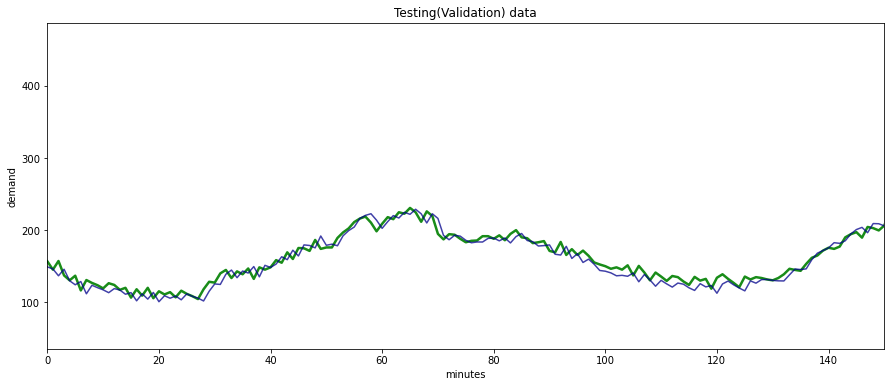

In [45]:
# 將預測值與實際值做圖表 [B]
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([0,150])
plt.ylabel("demand")
plt.xlabel("minutes")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict1[0], c = "darkblue", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()
# 將預測值與實際值做圖表 [E]

In [46]:
# 評估模型好壞 [B]
metrics.mean_absolute_error(y_test_true,testPredict1[0])
# 評估模型好壞 [E]

8.716625902555574

In [149]:
# 儲存模型 [B]
vanilla_model.save(simple_LSTM_modal_y1_save_path)  # creates a HDF5 file 'my_model.h5'
# 儲存模型 [E]

------------------------------------

# 情況 2: 使用 Bidirectional LSTM (many to one) + Self Attention 來訓練模型

In [126]:
''' 使用 Bidirectional LSTM (many to one) + Self Attention 來訓練模型 [B]'''
# 定義模型架構 [B]
bidirectional_model = Sequential()
bidirectional_model.add(Bidirectional(LSTM(50, activation='linear', return_sequences=True), input_shape=(train_features2_y2.shape[1],train_features2_y2.shape[2])))
bidirectional_model.add(SeqSelfAttention(attention_activation='softmax'))
bidirectional_model.add(Dropout(0.5))
bidirectional_model.add(Dense(1))
bidirectional_model.compile(optimizer='Adam', loss='mse')
bidirectional_model.summary()
# 定義模型架構 [E]
# 開始訓練 [B]
bidirectional_model_result = bidirectional_model.fit(train_features2_y2, all_train_labels_y2, epochs=2000, batch_size = 96, shuffle=False) #(50,72)
# 開始訓練 [E]
# 評估模型 [B]
scores = bidirectional_model.evaluate(train_features2_y2, all_train_labels_y2)
# 評估模型 [E]
''' 使用 Bidirectional LSTM (many to one) + Self Attention 來訓練模型 [E]'''

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 1, 100)           30000     
 onal)                                                           
                                                                 
 seq_self_attention_15 (SeqS  (None, 1, 100)           6465      
 elfAttention)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 1, 100)            0         
                                                                 
 dense_24 (Dense)            (None, 1, 1)              101       
                                                                 
Total params: 36,566
Trainable params: 36,566
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
706/706 [===========================

706/706 [==============================] - 2s 3ms/step - loss: 4.4290e-04
Epoch 83/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4402e-04
Epoch 84/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4433e-04
Epoch 85/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4539e-04
Epoch 86/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4290e-04
Epoch 87/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4468e-04
Epoch 88/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4302e-04
Epoch 89/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.3751e-04
Epoch 90/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4687e-04
Epoch 91/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4720e-04
Epoch 92/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.4950e-04
Epoch 93/2000
706/706 [=======================

706/706 [==============================] - 2s 3ms/step - loss: 4.3391e-04
Epoch 267/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.3274e-04
Epoch 268/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.3287e-04
Epoch 269/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.3039e-04
Epoch 270/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.3712e-04
Epoch 271/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2997e-04
Epoch 272/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.3182e-04
Epoch 273/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2731e-04
Epoch 274/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2913e-04
Epoch 275/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2962e-04
Epoch 276/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2909e-04
Epoch 277/2000
706/706 [============

706/706 [==============================] - 2s 3ms/step - loss: 4.2293e-04
Epoch 451/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2049e-04
Epoch 452/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2458e-04
Epoch 453/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2794e-04
Epoch 454/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2444e-04
Epoch 455/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2224e-04
Epoch 456/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1736e-04
Epoch 457/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2010e-04
Epoch 458/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2486e-04
Epoch 459/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2612e-04
Epoch 460/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2217e-04
Epoch 461/2000
706/706 [============

706/706 [==============================] - 2s 3ms/step - loss: 4.2359e-04
Epoch 635/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1988e-04
Epoch 636/2000
706/706 [==============================] - 2s 2ms/step - loss: 4.1900e-04
Epoch 637/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1934e-04
Epoch 638/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2093e-04
Epoch 639/2000
706/706 [==============================] - 2s 2ms/step - loss: 4.1807e-04
Epoch 640/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1654e-04
Epoch 641/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2299e-04
Epoch 642/2000
706/706 [==============================] - 2s 2ms/step - loss: 4.1905e-04
Epoch 643/2000
706/706 [==============================] - 2s 2ms/step - loss: 4.1643e-04
Epoch 644/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1995e-04
Epoch 645/2000
706/706 [============

706/706 [==============================] - 2s 2ms/step - loss: 4.1455e-04
Epoch 819/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1402e-04
Epoch 820/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1769e-04
Epoch 821/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1724e-04
Epoch 822/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2023e-04
Epoch 823/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1906e-04
Epoch 824/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1705e-04
Epoch 825/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1428e-04
Epoch 826/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1711e-04
Epoch 827/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1861e-04
Epoch 828/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1471e-04
Epoch 829/2000
706/706 [============

706/706 [==============================] - 2s 3ms/step - loss: 4.1322e-04
Epoch 1003/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1105e-04
Epoch 1004/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.2366e-04
Epoch 1005/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1174e-04
Epoch 1006/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1109e-04
Epoch 1007/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1651e-04
Epoch 1008/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1480e-04
Epoch 1009/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1507e-04
Epoch 1010/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1522e-04
Epoch 1011/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1203e-04
Epoch 1012/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1951e-04
Epoch 1013/2000
706/706 [=

706/706 [==============================] - 2s 3ms/step - loss: 4.1461e-04
Epoch 1185/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1643e-04
Epoch 1186/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1409e-04
Epoch 1187/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1141e-04
Epoch 1188/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1300e-04
Epoch 1189/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1566e-04
Epoch 1190/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1923e-04
Epoch 1191/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1926e-04
Epoch 1192/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1495e-04
Epoch 1193/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1456e-04
Epoch 1194/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1630e-04
Epoch 1195/2000
706/706 [=

706/706 [==============================] - 2s 3ms/step - loss: 4.0966e-04
Epoch 1367/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1633e-04
Epoch 1368/2000
706/706 [==============================] - 2s 3ms/step - loss: 4.1070e-04
Epoch 1369/2000
706/706 [==============================] - 4s 5ms/step - loss: 4.1678e-04
Epoch 1370/2000
706/706 [==============================] - 4s 5ms/step - loss: 4.1206e-04
Epoch 1371/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.0806e-04
Epoch 1372/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.1614e-04
Epoch 1373/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.1376e-04
Epoch 1374/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.1120e-04
Epoch 1375/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.1017e-04
Epoch 1376/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.1588e-04
Epoch 1377/2000
706/706 [=

706/706 [==============================] - 3s 4ms/step - loss: 4.1621e-04
Epoch 1549/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1715e-04
Epoch 1550/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1218e-04
Epoch 1551/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1294e-04
Epoch 1552/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.0857e-04
Epoch 1553/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1539e-04
Epoch 1554/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.0955e-04
Epoch 1555/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1289e-04
Epoch 1556/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1452e-04
Epoch 1557/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1341e-04
Epoch 1558/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1483e-04
Epoch 1559/2000
706/706 [=

706/706 [==============================] - 3s 4ms/step - loss: 4.1023e-04
Epoch 1731/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.1374e-04
Epoch 1732/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.0873e-04
Epoch 1733/2000
706/706 [==============================] - 3s 5ms/step - loss: 4.0970e-04
Epoch 1734/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1194e-04
Epoch 1735/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1631e-04
Epoch 1736/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1998e-04
Epoch 1737/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1553e-04
Epoch 1738/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1136e-04
Epoch 1739/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1266e-04
Epoch 1740/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1603e-04
Epoch 1741/2000
706/706 [=

706/706 [==============================] - 3s 4ms/step - loss: 4.1500e-04
Epoch 1913/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1610e-04
Epoch 1914/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1040e-04
Epoch 1915/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1487e-04
Epoch 1916/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1150e-04
Epoch 1917/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1044e-04
Epoch 1918/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1142e-04
Epoch 1919/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1190e-04
Epoch 1920/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1714e-04
Epoch 1921/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1376e-04
Epoch 1922/2000
706/706 [==============================] - 3s 4ms/step - loss: 4.1418e-04
Epoch 1923/2000
706/706 [=

In [130]:
testPredict1 = bidirectional_model.predict(predict_features2)

In [131]:
testPredict1 = demand_zscore.inverse_transform(testPredict1.reshape(1, -1))

In [132]:
y_test_true = reframed.loc[predict_begin_date:predict_end_date, 'demand_quarter(t)'].array

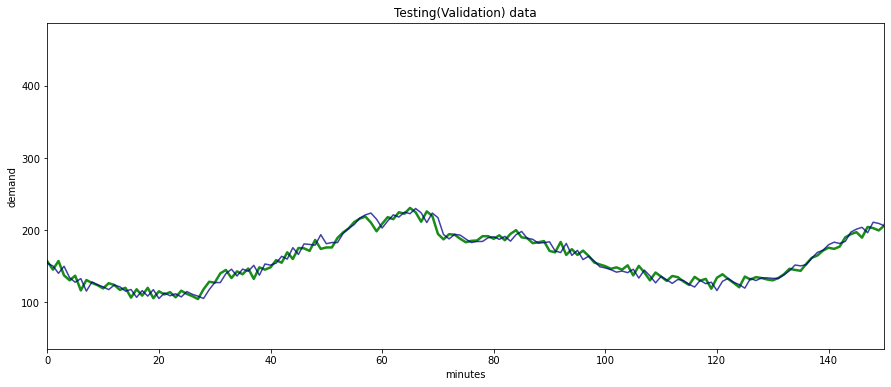

In [133]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([0,150])
plt.ylabel("demand")
plt.xlabel("minutes")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict1[0], c = "darkblue", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

In [150]:
# 儲存檔案最後更新檔案日期 [B]
vanilla_modal_pid_write = open(modal_pid_path, 'w', encoding='utf-8')
vanilla_modal_pid_write.write(today)
# stacked_modal_pid_write = open(stacked_modal_pid_path, 'w', encoding='utf-8')
# stacked_modal_pid_write.write(today)
# bidirectional_model_pid_write = open(bidirectional_modal_pid_path, 'w', encoding='utf-8')
# bidirectional_model_pid_write.write(today)
# simple_kmeans_modal_pid_write = open(simple_kmeans_modal_pid_path, 'w', encoding='utf-8')
# simple_kmeans_modal_pid_write.write(today)
# stacked_kmeans_modal_pid_write = open(stacked_kmeans_modal_pid_path, 'w', encoding='utf-8')
# stacked_kmeans_modal_pid_write.write(today)
# bidirectional_kmeans_model_pid_write = open(bidirectional_kmeans_modal_pid_path, 'w', encoding='utf-8')
# bidirectional_kmeans_model_pid_write.write(today)
print(today)
# 儲存檔案最後更新檔案日期 [E]

2022-07-29-10-53-04
